# Cuisine: Predicting your next plate

In this classification problem, the objective is to predict the type of cuisine given a recipe. Data was provided by Yummly through Kaggle. 

### __*Analysis of Data*__

In order to perform this task we applied the following procedure:
1. Language Processing and Feature Generation 
2. Data Visualization 
3. LinearSVC model
4. Random Forest Classifier
5. XGBoost

In [16]:
import json
import pandas as pd
import numpy as np # linear algebra
from collections import Counter
import nltk
nltk.download('wordnet')
from nltk.corpus.reader.wordnet import NOUN
from nltk.corpus import wordnet
from nltk.compat import python_2_unicode_compatible
import re
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn.feature_extraction.text import TfidfVectorizer
import gc
from sklearn.metrics import f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import sklearn
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import warnings
warnings.filterwarnings("ignore")



# Model imports
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#visualization
import matplotlib.pyplot as plt
import seaborn as sns


# Read in data
traindf = pd.read_json("train.JSON")

[nltk_data] Downloading package wordnet to C:\Users\Preston
[nltk_data]     Overson\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


The data consists of lists of ingredients, and labels indicating the type of cuisine. First we wanted to simplify the ingrediant lists. We did this by using a word lemmatizer to consolidate similar words. For example eggs become egg. This should reduce the number of features in our dataset without losing information.

In [4]:
#Running Word Lemmatization
traindf['ingredients_clean_string'] = [' , '.join(z).strip() for z in traindf['ingredients']]  
traindf['ingredients_string'] = [' '.join([WordNetLemmatizer().lemmatize(re.sub('[^A-Za-z]', ' ', line)) for line in lists]).strip() for lists in traindf['ingredients']]  

The lemmatizer worked decently well. After simplifying the ingrediants we then needed to create dummy variables for each incrediant in the dataset and fill in each dummy variable with the ingredients from each recipe. This was important because it allowed us to create a dataset to help us perform our modeling. In our first attempt we used a for loop that took each ingredient in a unique ingredient list and created a column for that ingredient, then went through each recipe and inputed a 1 or 0 if the ingredient was found. Because we it was 3 for loops on 2 large dataset, our computer ran all night and still did not produce results. So we tried something else. In our second attempt we used vectorization to create matrix of our data that was easier and much faster for our machine to produce results.

In [5]:
# Running Vectorizer
corpus = traindf['ingredients_string']
vectorizertr = TfidfVectorizer()
train_vect=vectorizertr.fit_transform(corpus).todense()

We wanted to do a little more data exploration and so we plotted a graph to give us a good idea of just how much data we were working with. We also did this so we had a good grasp on the data to make sure things added up. In this plot you can observe how balanced the classes are. Some classes such as brazilian, korean and russian are under represented in the data.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

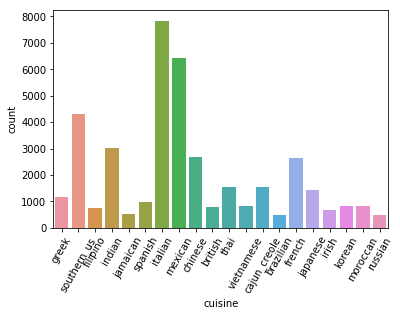

In [6]:
sns.countplot(x="cuisine", data=traindf)
plt.xticks(rotation=60)

Looking at the shape of our dataset, we have 39774 observations and 2996 unique ingrediants (features)

In [7]:
train_vect.shape

(39774, 2996)

In [8]:
# defining the target variable cuisine
target = traindf['cuisine']
train_vect

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [9]:
# Getting feature names
features = vectorizertr.get_feature_names()

In [10]:
# Getting our train and test datasets 
X_train, X_test, y_train, y_test = train_test_split(train_vect, target, test_size=0.30, random_state=42)

### __*Model (LinearSVC Support Vector Machine Classifier)*__

This models attempt to fit a hyperplane in order to seperate the data in multiple dimensions. It uses the points that are closests to the hyperplane to define seperation between classes. In cases where there is mulitple classes like this data, multiple models are created in a one verse all situation and each model will vote on the dominant class. Because of this models nature we felt it would be perfect with our data.

Right off the bat the default parameters performed really well and the F1 score was comparable to other competitors on Kaggle. We wanted to see if we could improve our score and see how high we could get.

In [11]:
# Fitting and Predicting using default LinearSVC
model = LinearSVC().fit(X_train, y_train)
pred = model.predict(X_test)
f1 = f1_score(y_test,pred, average='weighted')
print(f1)

0.7816523188241796


Here we applied our tuning. Using GridSearchCV (cross validation) we searched for the five recommended c-values as our starting point. A c-value is a hyperparameter that adjusts the amount of penalty for misclassification. 

In [14]:
# Defining a tuning GridSearchCV method
from sklearn.model_selection import GridSearchCV
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    param_grid = {'C': Cs}
    grid_search = GridSearchCV(LinearSVC(), param_grid= param_grid, scoring=make_scorer(f1_score, average='weighted'))
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [17]:
svc_param_selection(train_vect,target,10)

{'C': 1}

Our tuning found that 1 was the best value. We figured that values close to one could help us gage what direction to go to see if we could climb a bit higher in our F1

In [18]:
# Redefining using different C-values
def svc_param_selection(X, y, nfolds):
    Cs = [.25, .5, 1, 1.5, 2]
    param_grid = {'C': Cs}
    grid_search = GridSearchCV(LinearSVC(), param_grid= param_grid, scoring=make_scorer(f1_score, average='weighted'))
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_
svc_param_selection(train_vect,target,10)

{'C': 0.5}

In [19]:
# Redefining using different C-values
def svc_param_selection(X, y, nfolds):
    Cs = [.4, .5, .6, .7, .3]
    param_grid = {'C': Cs}
    grid_search = GridSearchCV(LinearSVC(), param_grid= param_grid, scoring=make_scorer(f1_score, average='weighted'))
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_
svc_param_selection(train_vect,target,10)

{'C': 0.5}

After tuning we found that the best c-value would be 0.5 and applied that to our model and then fitted the model to our entire training set. We then predicted on the test set and got a sweet F1 score! 

In [ ]:
#Fitting and Predicting optimal tuned SVC
model = LinearSVC(C=.5).fit(X_train, y_train)
pred = model.predict(X_test)
f1 = f1_score(y_test,pred, average='weighted')
print(f1)

In order to check for overfitting we plotted the learning curve. Looking at the learning curve we observe that the training score and the cross validation score are both increasing and converging. Even thought the model is overfitting a little bit the fact that it is converging and the cross validation set is still doing well, overfitting is not huge issue in this case.

In [21]:
#Graphing learning_curve
## source: http://scikit-learn.org/0.15/auto_examples/plot_learning_curve.html
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=make_scorer(f1_score, average='weighted'))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

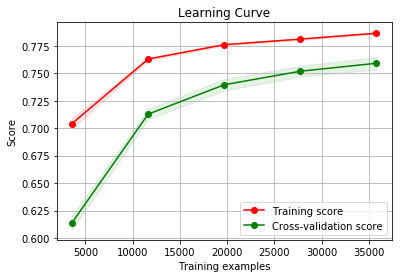

In [22]:
plot_learning_curve(LinearSVC(C=.05), "Learning Curve", train_vect, target, cv=10)
plt.savefig('SVCLearningCurve.png')

## Random Forest Classifier

This is the first ensemble model that we tried. This model uses n number of weak decision trees to vote on the classification of an observation. This model tends to perform well on multiclass problems such as ours, so we decided to try it. 

Below we perform an intiial search on both depth and number of trees, to tune the model for better accuracy. We started with a more reserved number of trees, due to the size of the data, which caused the RCF to take a long time to fit.

In [23]:
n_estimators = [500, 1000, 2500]
max_depth = [1, 3, 5]
best_f1 = 0

for est in n_estimators:
    for depth in max_depth:
        clf = RandomForestClassifier(n_estimators=est, max_depth=depth, oob_score=True, class_weight='balanced')
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)
        f1 = f1_score(y_test, pred, average='weighted')
        print (est, '  ', depth, '  ', f1)
        if f1 > best_f1:
            best_f1 = f1

500    1    0.5444872805744317
500    3    0.5585761726293346
500    5    0.5817772001136959
1000    1    0.5217335460990721
1000    3    0.5627226794754643
1000    5    0.590207926389359
2500    1    0.52062016399474
2500    3    0.5646968738044137
2500    5    0.5874070944053275


Already, this model seems to be underfitting compared to the Support Vector Machine. We will try some higher values of n and depth, as those seem to be improving the F1 score.

As seen below, increasing the number of trees and depth helped the model to improve quite a bit. However, due to the length of time it is taking to search (4+hours), and the significantly lower F1 score compared to the SVM, the cost of further tuning on this model is greater than the benefit.

In [24]:
n_estimators = [5000, 7500]
max_depth = [5, 7]
best_f1 = 0

for est in n_estimators:
    for depth in max_depth:
        clf = RandomForestClassifier(n_estimators=est, max_depth=depth, oob_score=True, class_weight='balanced')
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)
        f1 = f1_score(y_test, pred, average='weighted')
        print (est, '  ', depth, '  ', f1)
        if f1 > best_f1:
            best_f1 = f1

5000    3    0.5650986839069996
5000    5    0.5939635978067714
5000    7    0.6125450226729603
7500    3    0.5644774205596066
7500    5    0.5910295090578808
7500    7    0.6125337830780911


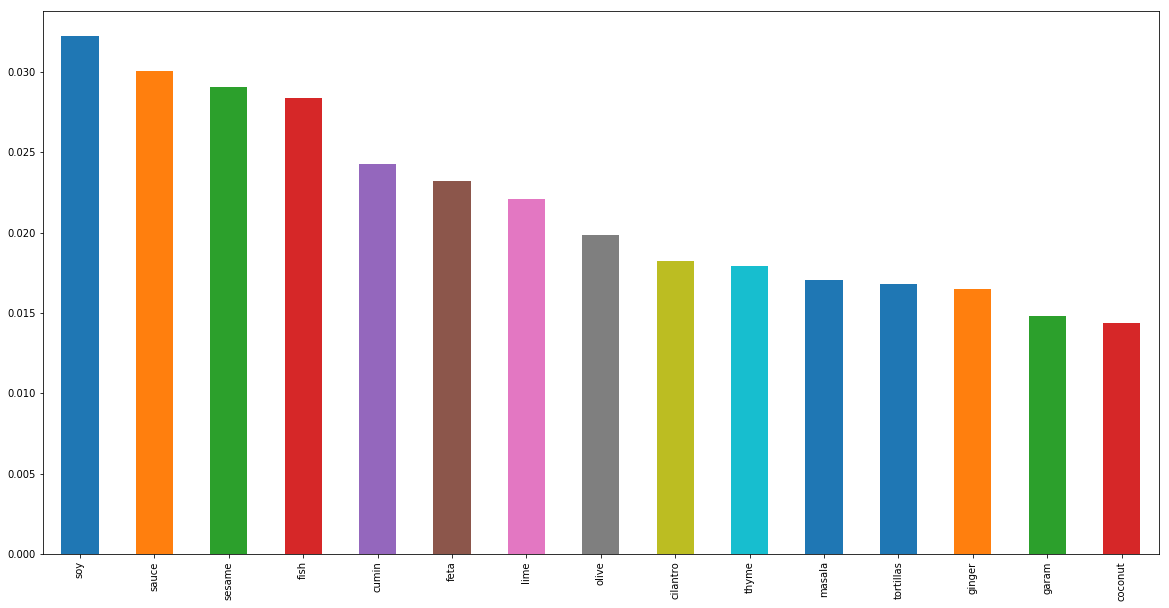

In [32]:
feature_imp = sorted(list(zip(features, clf.feature_importances_)), key=lambda x: x[1], reverse=True)
feat_imp_short = feature_imp[:15]
plt.figure(figsize=(20, 10))
pd.Series([x[1] for x in feat_imp_short], index=[x[0] for x in feat_imp_short]).plot(kind='bar')
plt.savefig('featimport.png')

## XGBoost

This is a versitle ensemble model that is similar to random forest, in that it uses voting with a combination of trees. It is unique in that each new model that it adds is trained on the errors of the previous model. This algorithm can be highly effective in many situstions. 

In this case, the data set was so large that tuning the model was near impossible. We started with a grid search of around 1000 trees, however after running it for 4 hours, had to abort it. We tried again, running the model overnight, and into the next day using 500, 1000, and 2500 trees, but after nearly 12 hours the model had only outputed information on the models fit with 500 trees. While the output on this test was promising (F1= 0.77), the shear amount of time required to run this model makes it almost unusable in this application. The code for XGBoost is included in this folder, but could not be included here, because of its extended runtime.